In [34]:
import kaggle
import subprocess
import zipfile
import pandas as pd
import pandas as pd
import numpy as np

# Télécharger le dataset depuis Kaggle
subprocess.run(["kaggle", "datasets", "download", "-d", "retailrocket/ecommerce-dataset"])

# Décompresser le fichier zip téléchargé
with zipfile.ZipFile('ecommerce-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('../data/')

# Charger les fichiers CSV dans des DataFrames Pandas
category_tree = pd.read_csv('../data/category_tree.csv')
events = pd.read_csv('../data/events.csv')
item_properties_part1 = pd.read_csv('../data/item_properties_part1.csv')
item_properties_part2 = pd.read_csv('../data/item_properties_part2.csv')

# Afficher les premières lignes de chaque DataFrame pour inspection
print("Category Tree:")
print(category_tree.head())

print("\n Events:")
print(events.head())

print("\n Item Properties Part 1:")
print(item_properties_part1.head())

print("\n Item Properties Part 2:")
print(item_properties_part2.head())

Category Tree:
   categoryid  parentid
0        1016     213.0
1         809     169.0
2         570       9.0
3        1691     885.0
4         536    1691.0

 Events:
       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN

 Item Properties Part 1:
       timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014         400  n552.000 639502 n720.000 424566
3  1431226800000   59481         790                       n15360.000
4  1431831600000  156781         917                           828513

 Item Properties Part 2:
       timestamp 

I. Nettoyage des données pour faciliter mes analyses

vérification des valeurs manquantes

In [35]:
# suppression des doublons: 
category_tree= category_tree.drop_duplicates()
events= events.drop_duplicates()
item_properties_part1= item_properties_part1.drop_duplicates()
item_properties_part2= item_properties_part2.drop_duplicates()

# verification des valeurs manquantes
print(f" valeurs manquantes pour la table item_properties_part1 : \n{item_properties_part1.isnull().sum()}\n\n")
print(f" valeurs manquantes pour la table item_properties_part2 : \n{item_properties_part2.isnull().sum()}\n\n")
print(f" valeurs manquantes pour la table events : \n{events.isnull().sum()}\n\n")
print(f" valeurs manquantes pour la table category_tree : \n{category_tree.isnull().sum()}\n\n")

 valeurs manquantes pour la table item_properties_part1 : 
timestamp    0
itemid       0
property     0
value        0
dtype: int64


 valeurs manquantes pour la table item_properties_part2 : 
timestamp    0
itemid       0
property     0
value        0
dtype: int64


 valeurs manquantes pour la table events : 
timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733184
dtype: int64


 valeurs manquantes pour la table category_tree : 
categoryid     0
parentid      25
dtype: int64




 Analyse des valeurs manquantes :
 -Table item_properties_part1 et item_properties_part2 : Aucune valeur manquante, données complètes.
 -Table events : transactionid manquant pour 2733184 lignes, indiquant des événements sans transaction (qui peut être par ex un produit vues, ajouts au # panier). ⚠️ L'analyse peut donc être eronnée du fait qu'elle soit incomplète. Il faut donc se poser la question si ces abscences ont ou non des répercutions sur notre analyse.
- Table categorie : parentid manquant pour 25 catégories, probablement des catégories racines. ⚠️ Peut impacter l’analyse des # hiérarchies. On se posela même question ici

II Analyse de la table events 

1 Affichage des élèments de la table 

In [36]:
print(f"tête de la table : \n \n{events.head()}")

tête de la table : 
 
       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN


In [37]:
#Conversion de la colonne "timestamp" au format de la date lisible : 
events["timestamp"] = pd.to_datetime(events["timestamp"], unit="ms")
print(events.head())

                timestamp  visitorid event  itemid  transactionid
0 2015-06-02 05:02:12.117     257597  view  355908            NaN
1 2015-06-02 05:50:14.164     992329  view  248676            NaN
2 2015-06-02 05:13:19.827     111016  view  318965            NaN
3 2015-06-02 05:12:35.914     483717  view  253185            NaN
4 2015-06-02 05:02:17.106     951259  view  367447            NaN


In [38]:
#On va voir les autres valeurs différentes de NaN de "transactionid"
value_transactionid = events.groupby('transactionid').size()
print(f"different valeurs de transactionid : \n \n{value_transactionid}")

different valeurs de transactionid : 
 
transactionid
0.0        1
1.0        1
2.0        1
3.0        1
4.0        1
          ..
17667.0    1
17668.0    1
17669.0    2
17670.0    1
17671.0    1
Length: 17672, dtype: int64


In [39]:
# Filtrer et afficher uniquement les lignes où transactionid est NaN
value_transactionid = events[events['transactionid'].isna()]

print(f"Valeurs avec transactionid manquant :\n\n{value_transactionid}")

Valeurs avec transactionid manquant :

                      timestamp  visitorid event  itemid  transactionid
0       2015-06-02 05:02:12.117     257597  view  355908            NaN
1       2015-06-02 05:50:14.164     992329  view  248676            NaN
2       2015-06-02 05:13:19.827     111016  view  318965            NaN
3       2015-06-02 05:12:35.914     483717  view  253185            NaN
4       2015-06-02 05:02:17.106     951259  view  367447            NaN
...                         ...        ...   ...     ...            ...
2756096 2015-08-01 03:13:05.939     591435  view  261427            NaN
2756097 2015-08-01 03:30:13.142     762376  view  115946            NaN
2756098 2015-08-01 02:57:00.527    1251746  view   78144            NaN
2756099 2015-08-01 03:08:50.703    1184451  view  283392            NaN
2756100 2015-08-01 03:36:03.914     199536  view  152913            NaN

[2733184 rows x 5 columns]


A partir de cette analyse, nous pouvons conclure que les produits dans "transactionid" avec des valeurs NaN ont été consultés mais n'ont pas été achetés par les visiteurs.

In [40]:
#A présent, dans la colone "evens" nous allons voir si les personnes ont seulement vu, ou ont fait d'autres choses
event_attributes = events.groupby("event").size()
print(f"size_event : \n{event_attributes}")

size_event : 
event
addtocart        68966
transaction      22457
view           2664218
dtype: int64


On remarque qu'il y a 3 types d'évenements dans cette catégories: ceux qui ont ajoutés au panier, acheté, vu.


C:\Users\LEM-L3560-05\AppData\Local\Temp\ipykernel_23168\2405029667.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_attributes.index, y=event_attributes.values, palette="viridis")


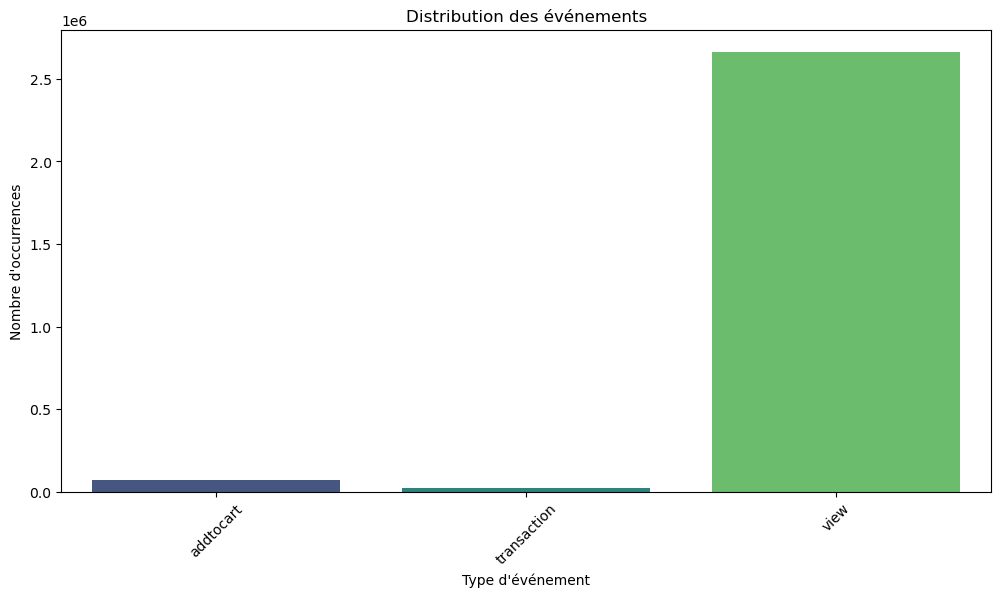

In [42]:
# Nous allons representer ça sous forme d'un graphique pour avoir une idée de l'ordre de grandeur 
import matplotlib.pyplot as plt
import seaborn as sns

# Création du graphique
plt.figure(figsize=(12, 6))
sns.barplot(x=event_attributes.index, y=event_attributes.values, palette="viridis")

# Ajout des titres et labels
plt.xlabel("Type d'événement")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution des événements")
plt.xticks(rotation=45)  # Rotation des labels pour une meilleure lisibilité

# Affichage du graphique
plt.show()